(optional)

In [ ]:
# from google.colab import drive
# import os
# drive.mount('/content/drive')

In [ ]:
# os.chdir('...')

# **HW5: Brain signal classification**
In *HW 5*, you need to finish:

1.  Model Implementation Part: Implement LSTM and EEGNet models to predict the label of each samples.

2.  Model Competition Part: Implementing a model to reach better accuracy performance.

In [1]:
import numpy as np
import os
import math
import csv
import matplotlib.pyplot as plt
# Import the packages you need here
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy

In [2]:
data = np.load('data.npz')
label = np.load('label.npz')

In [3]:
X_train = data['X_train']
X_val = data['X_val']
X_test = data['X_test']

Y_train = label['Y_train']
Y_val = label['Y_val']

In [4]:
X_train.shape, X_val.shape, X_test.shape

((604, 22, 200), (152, 22, 200), (190, 22, 200))

In [5]:
def change_dim(X):
    temp = []
    for i in range(len(X)):
        temp.append(X[i].T.copy())
    return np.array(temp)

X_train = change_dim(X_train)
X_val = change_dim(X_val)
X_test = change_dim(X_test)

print(X_train.shape, X_val.shape, X_test.shape)

(604, 200, 22) (152, 200, 22) (190, 200, 22)


In [6]:
Y_train.shape, Y_val.shape

((604, 1), (152, 1))

In [7]:
Y_train = tf.keras.utils.to_categorical(Y_train, 6)
Y_val = tf.keras.utils.to_categorical(Y_val, 6)

print(Y_train.shape, Y_val.shape)

(604, 6) (152, 6)


## Model Implementation Part

### LSTM

In [8]:
# Build your model here:
model = models.Sequential()

model.add(layers.LSTM(units=64, input_shape=(200, 22), dropout=0.2))

model.add(layers.Dense(units=6, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 64)                22272     
                                                                 
 dense (Dense)               (None, 6)                 390       
                                                                 
Total params: 22,662
Trainable params: 22,662
Non-trainable params: 0
_________________________________________________________________


In [9]:
model.compile(optimizer=Adam(),
              loss=CategoricalCrossentropy(),
              metrics=['accuracy'])

train_history = model.fit(X_train, Y_train,
                          validation_data=(X_val, Y_val),
                          batch_size=64,
                          epochs=100,
                          verbose=1)

Epoch 1/100
10/10 [==============================] - 3s 89ms/step - loss: 1.9043 - accuracy: 0.1887 - val_loss: 1.8634 - val_accuracy: 0.2039
Epoch 2/100
10/10 [==============================] - 0s 21ms/step - loss: 1.6942 - accuracy: 0.2798 - val_loss: 1.6729 - val_accuracy: 0.2895
Epoch 3/100
10/10 [==============================] - 0s 20ms/step - loss: 1.5468 - accuracy: 0.3940 - val_loss: 1.5532 - val_accuracy: 0.3816
Epoch 4/100
10/10 [==============================] - 0s 18ms/step - loss: 1.4445 - accuracy: 0.4570 - val_loss: 1.4775 - val_accuracy: 0.4408
Epoch 5/100
10/10 [==============================] - 0s 17ms/step - loss: 1.3633 - accuracy: 0.5298 - val_loss: 1.4096 - val_accuracy: 0.4474
Epoch 6/100
10/10 [==============================] - 0s 18ms/step - loss: 1.3018 - accuracy: 0.5199 - val_loss: 1.3645 - val_accuracy: 0.4671
Epoch 7/100
10/10 [==============================] - 0s 18ms/step - loss: 1.2295 - accuracy: 0.5745 - val_loss: 1.3168 - val_accuracy: 0.4934
Epoch 

Train loss: 0.022621488198637962
Train accuracy: 0.9933775067329407
Validation loss: 0.3007522523403168
Validation accuracy: 0.9210526347160339


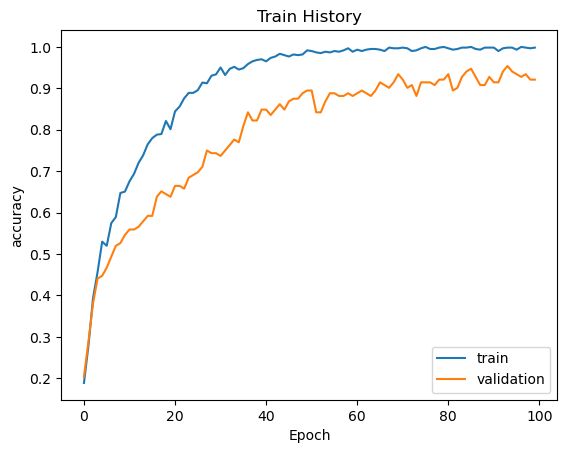

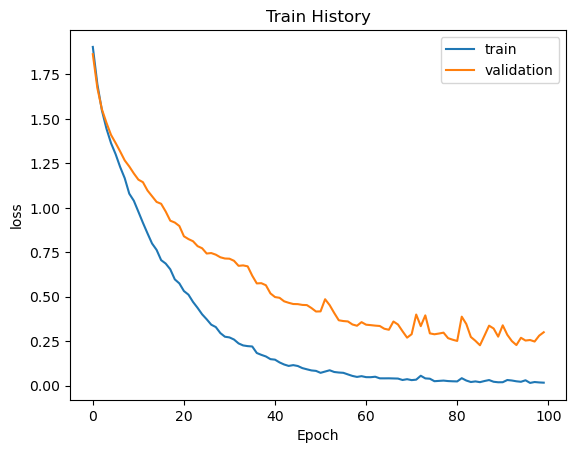

In [10]:
pred_train = model.evaluate(X_train, Y_train, verbose=0)
pred_val = model.evaluate(X_val, Y_val, verbose=0)

print("Train loss:", pred_train[0])
print("Train accuracy:", pred_train[1])
print("Validation loss:", pred_val[0])
print("Validation accuracy:", pred_val[1])

plt.plot(train_history.history['accuracy'])
plt.plot(train_history.history['val_accuracy'])
plt.title('Train History')
plt.ylabel('accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='lower right')
plt.show()

plt.plot(train_history.history['loss'])
plt.plot(train_history.history['val_loss'])
plt.title('Train History')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [11]:
pred_test = model.predict(X_test)
pred_test = np.argmax(pred_test, axis = 1)
pred_test = pred_test.reshape((-1, 1))

6/6 [==============================] - 0s 6ms/step


In [ ]:
output = pred_test
assert(output.shape == (190, 1))
np.savetxt('lstm_output.csv', output, delimiter=",", fmt='%i')

### EEGNet

In [ ]:
# Build your model here:


In [ ]:
output = "..."
assert(output.shape == (190, 1))
np.savetxt('eegnet_output.csv', output, delimiter=",")

## Model Competition Part

In [ ]:
# Build your model here:


In [ ]:
output = "..."
assert(output.shape == (190, 1))
np.savetxt('competition_output.csv', output, delimiter=",")